In [1]:
# Import necessary libraries
import yfinance as yf
from pymongo import MongoClient
from datetime import datetime
import matplotlib.pyplot as plt
import pymongo
import pandas as pd
import requests
from bson import ObjectId

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTMCell, LSTM
from tensorflow.keras.models import load_model, save_model
from tensorflow import function
from bson.binary import Binary
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def connect_to_db():
    with open('../server/config.env', 'r') as file:
        connection_string = file.read().strip()

    connection_string = connection_string.replace('ATLAS_URI=', '')

    client = pymongo.MongoClient(connection_string)
    db = client['bullsai']
    return db

def download_data(symbol, start_date, end_date):
    db = connect_to_db()
    collection = db['ticker_data']
    data = collection.find_one({"symbol": symbol})

    if data is not None and 'transactions' in data:
        # Convert the data to a DataFrame
        dataDF = pd.DataFrame(data['transactions'])
        dataDF = dataDF.set_index('Date')

        # Convert the index to datetime
        dataDF.index = pd.to_datetime(dataDF.index)

        # Filter the data for the date range
        mask = (dataDF.index >= start_date) & (dataDF.index <= end_date)
        dataDF = dataDF.loc[mask]
        return dataDF

    return None

def create_dataset(data):
    data = data.filter(['Adj Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return dataset, training_data_len

def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(dataset), scaler

def create_training_data(scaled_data, training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    return np.array(x_train), np.array(y_train)

def reshape_data(x_train):
    return np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

def build_and_train_model(x_train, y_train):
    model = Sequential()
    # model.add(RNN(LSTMCell(128), return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # model.add(RNN(LSTMCell(64), return_sequences=False))
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=2)
    return model

def create_test_data(scaled_data, dataset, training_data_len):
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    return np.array(x_test), y_test

def make_predictions(model, x_test, scaler):
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def calculate_rmse(predictions, y_test):
    return np.sqrt(np.mean(((predictions - y_test) ** 2)))

def plot_data(data, training_data_len, predictions, symbol):
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()
    valid.loc[:, 'Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title(symbol + ' Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price SGD ($)', fontsize=18)
    plt.plot(train['Adj Close'])
    plt.plot(valid[['Adj Close', 'Predictions']])
    # plt.gcf().autofmt_xdate()  # update this line
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

def save_model(model, model_path):
    model.save(model_path)

def load_model_if_exists(model_path):
    if os.path.exists(model_path):
        return load_model(model_path)
    else:
        return None
    
def load_model_from_db(symbol):
    # Connect to MongoDB
    db = connect_to_db()
    collection = db['models']
    doc = collection.find_one({'symbol': symbol})

    if doc is not None:
        print(f"Document found for symbol {symbol}")
        if 'model' in doc:
            print("Model key found in document")
            binary_model = doc['model']
            # Write the binary model to a file
            with open('model.h5', 'wb') as f:
                f.write(binary_model)
            # Load the model from the file
            model = load_model('model.h5')
            # Delete the temporary file
            os.remove('model.h5')
        else:
            print("Model key not found in document")
            model = None
    else:
        print(f"No document found for symbol {symbol}")
        model = None

    return model

def save_model_to_db(model, symbol):
    # Save the model to a file
    model.save('model.h5')

    # Read the model file and convert it to binary
    with open('model.h5', 'rb') as f:
        binary_model = Binary(f.read())

    # Connect to MongoDB
    db = connect_to_db()
    collection = db['models']

    # Store the binary model in MongoDB
    collection.update_one({'symbol': symbol}, {'$set': {'model': binary_model}}, upsert=True)

    # Delete the temporary file
    os.remove('model.h5')

No document found for symbol U96.SI
No model found for symbol U96.SI. Please train a model first.
Epoch 1/2
5684/5684 [==============================] - 100s 17ms/step - loss: 4.5609e-04
Epoch 2/2
5684/5684 [==============================] - 95s 17ms/step - loss: 1.9424e-04


/Users/darrels/miniforge3/envs/tf_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 56ms/step


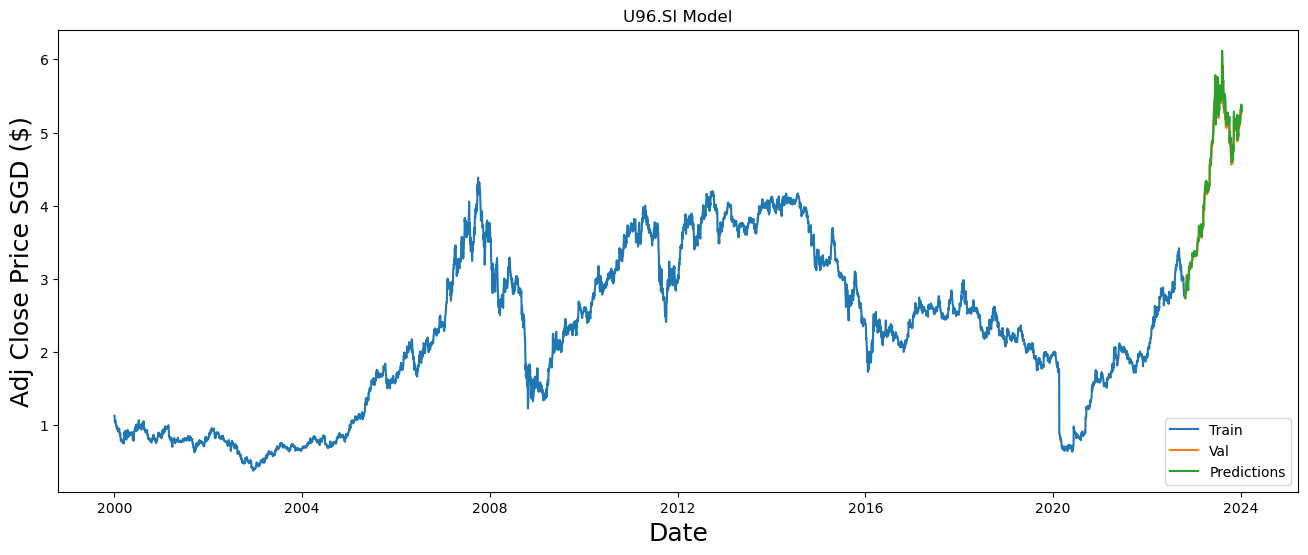

In [6]:
def main(symbol, start_date, end_date):
    # model_path = f"models/{symbol}_model.h5"
    
    # Use the new download_data function
    data = download_data(symbol, start_date, end_date)

    if data is None:
        print(f"No data found on {symbol} Exiting.")
        return

    dataset, training_data_len = create_dataset(data)
    scaled_data, scaler = scale_data(dataset)
    
    # Use the new load_model_from_db function
    model = load_model_from_db(symbol)

    if model is None:
        print(f"No model found for symbol {symbol}. Please train a model first.")

        # Create the training data
        x_train, y_train = create_training_data(scaled_data, training_data_len)
        x_train = reshape_data(x_train)

        # Build and train the model
        model = build_and_train_model(x_train, y_train)

        # Save the model to MongoDB
        save_model_to_db(model, symbol)
    else:
        print(f"Model found for symbol {symbol}. Using existing model.")
        # return

    x_test, y_test = create_test_data(scaled_data, dataset, training_data_len)
    predictions = make_predictions(model, x_test, scaler)
    plot_data(data, training_data_len, predictions, symbol)

if __name__ == "__main__":
    main("U96.SI", "2000-01-01", datetime.today())